In [ ]:
INPUT Shape= 224*224 
Batch_Size = 64

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset Labels

train_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train/_annotations.csv')
test_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test/_annotations.csv')
valid_df = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid/_annotations.csv')

In [4]:
# Creating Image DataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
# Training data generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 28518 validated image filenames belonging to 6 classes.


In [6]:
# Validation data generator

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 3581 validated image filenames belonging to 6 classes.


In [7]:
# Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 3466 validated image filenames belonging to 6 classes.


In [8]:
# Confirmation of split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(valid_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 28518
Validation samples: 3581
Test samples: 3466


In [9]:
# Define Fine Tuned CNN Architecture 

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(6, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Printing Model Details

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 140)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 124)  │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 53, 53, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 380)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 54720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    25,171,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,569,618 (97.54 MB)

 Trainable params: 25,569,618 (97.54 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model Training

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718753072.902649     454 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718753072.923963     454 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


262/445 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.5163 - loss: 1.5597

W0000 00:00:1718753199.808331     457 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5727 - loss: 1.3038

W0000 00:00:1718753269.230897     454 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


445/445 ━━━━━━━━━━━━━━━━━━━━ 267s 485ms/step - accuracy: 0.5730 - loss: 1.3028 - val_accuracy: 0.7491 - val_loss: 0.6007
Epoch 2/20
  1/445 ━━━━━━━━━━━━━━━━━━━━ 2:22 321ms/step - accuracy: 0.7500 - loss: 0.6130

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


445/445 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7500 - loss: 0.6130 - val_accuracy: 0.7213 - val_loss: 0.6605
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 184s 407ms/step - accuracy: 0.7525 - loss: 0.6043 - val_accuracy: 0.7599 - val_loss: 0.6158
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.6562 - loss: 0.6990 - val_accuracy: 0.8361 - val_loss: 0.4173
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 185s 410ms/step - accuracy: 0.7554 - loss: 0.5827 - val_accuracy: 0.7642 - val_loss: 0.5524
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.7656 - loss: 0.5119 - val_accuracy: 0.7869 - val_loss: 0.5878
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 184s 407ms/step - accuracy: 0.7710 - loss: 0.5219 - val_accuracy: 0.7830 - val_loss: 0.4934
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - accuracy: 0.7188 - loss: 0.5627 - val_accuracy: 0.8197 - val_loss: 0.4964
Epoch 9/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 185s 409ms/step - accuracy: 0.7767 - loss: 0.5097 - val

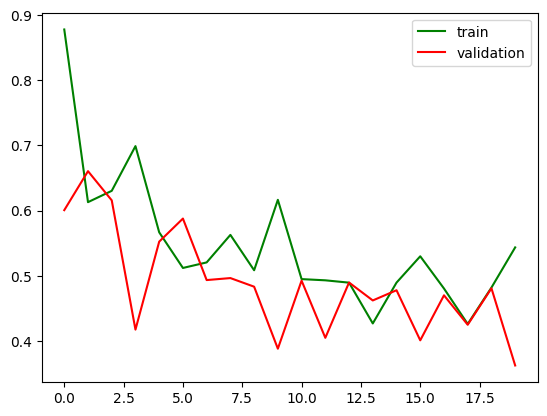

In [13]:
# Ploting Val_Accuracy & Val_Loss Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


plt.plot(history.history['loss'],color='Green',label='train')
plt.plot(history.history['val_loss'],color='red',label='validation')
plt.legend()
plt.show()

In [14]:
# Model Evaluation

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.7894 - loss: 0.4606
Test loss: 0.4569782018661499
Test accuracy: 0.7931134104728699


In [15]:
# Printing Classification Report
test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 2/55 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step  

W0000 00:00:1718754987.054906     455 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 411ms/step
              precision    recall  f1-score   support

        crab       0.36      0.44      0.39      1279
        fish       0.06      0.03      0.04       321
   jellyfish       0.00      0.00      0.00        62
      shrimp       0.00      0.00      0.00        57
  small_fish       0.30      0.34      0.32       965
    starfish       0.25      0.20      0.22       782

    accuracy                           0.30      3466
   macro avg       0.16      0.17      0.16      3466
weighted avg       0.28      0.30      0.29      3466



W0000 00:00:1718755009.259360     456 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


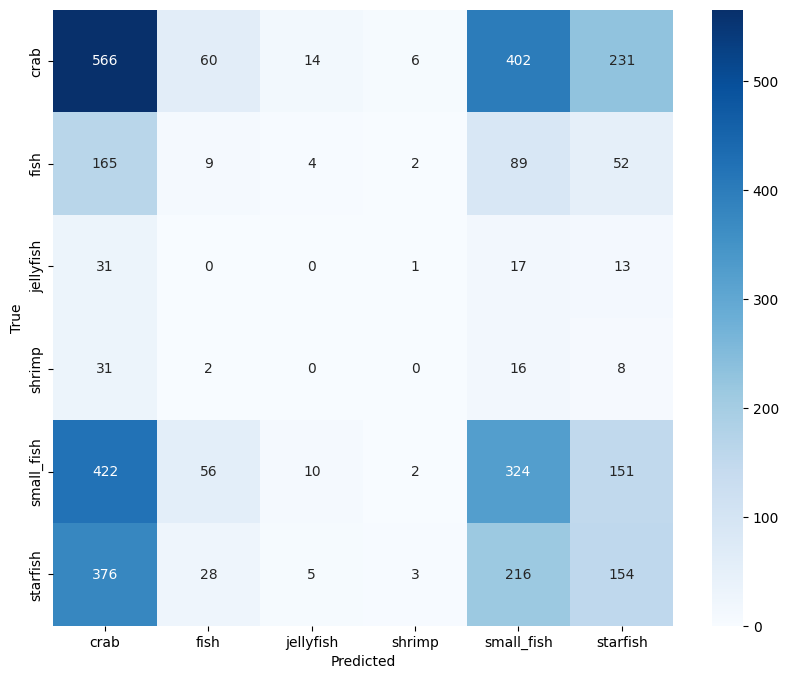

In [16]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.2784895777243098
Recall: 0.3038084246970571
F1 Score: 0.28792634054398153


In [18]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [19]:
# Save the VGG16 model
model.save('CACNN_Brackish(79.31%).h5')